In [1]:
import sys
sys.path.append('../data/')
sys.path.append('../src/')
sys.path.append('../libs/')

import numpy as np
import tensorflow as tf
import scipy.linalg as la
import matplotlib.pyplot as plt

import MNIST_DATA

<h1>Handwritten Digits</h1>

In [2]:
mnist = MNIST_DATA.MNIST_DATA()
n_images = len(mnist.train_data)

<h2>Graph Convolutional Network</h2>

It doesn't make sense to slide a filter over a graph, so graph convolutional networks use a definition of convolution by analogy. In a Euclidean space, the convolution of two signals in the frequency domain is the product of the signals in the frequency domain. Similarly, for two signals $f$ and $g$ defined in vertex space, the convolution is
\begin{equation}
    f \star g = \sum^n_{k = 1} \left( \hat f_k \hat g_k \right) u_k
\end{equation}
where $\hat f_k, \hat g_k$ are coefficients of the $k$th frequency component, and $u_k$ is the basis vector corresponding to the $k$th frequency component.

Frequency components are obtained by the Graph Fourier Transform (GFT). If $G$ is a graph with Laplacian $L$, then the Fourier basis for a signal $x$ defined over the vertices of $G$ are the columns of the orthonormal matrix $U$, defined by the spectral decomposition $L = U^T \Lambda U$. Hence, if $x$ is a signal in the vertex domain, the corresponding frequency domain signal is $\hat x = U^T x$.

<h3>Lattice Frequency Domain</h3>

All of the handwritten digits are defined over the same graph, a 28 $\times$ 28 lattice. We can obtain the normalized Laplacian as follows:

In [4]:
def get_lattice_laplacian(n):
    d, I = la.toeplitz(np.eye(1, n, 1)), np.eye(n)
    A = np.kron(d, I) + np.kron(I, d)
    degrees = np.sum(A, axis = 0)
    N = np.diag(np.power(degrees, -0.5))
    L = np.identity(n ** 2) - np.linalg.multi_dot([N, A, N])
    return L

Let's see what some of the frequency components look like for the lattice graph.

In [5]:
L = get_lattice_laplacian(28)
lamb, U = np.linalg.eig(L)

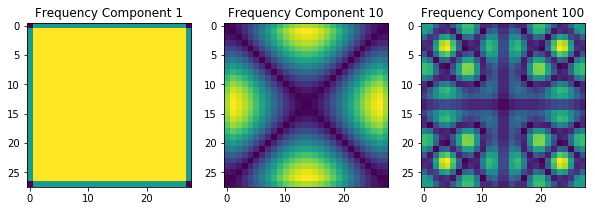

In [6]:
plt.figure(figsize = (10, 5))
plt.subplot(1, 3, 1)
plt.imshow(np.abs(np.reshape(U[:, 0], (28, 28))))
plt.title('Frequency Component 1')
plt.subplot(1, 3, 2)
plt.imshow(np.abs(np.reshape(U[:, 9], (28, 28))))
plt.title('Frequency Component 10')
plt.subplot(1, 3, 3)
plt.imshow(np.abs(np.reshape(U[:, 99], (28, 28))))
plt.title('Frequency Component 100')
plt.show()

We get some cool and weird patterns, whose complexity increases with frequency. By taking a linear combination of these frequency component images, we can reconstruct any image defined over the lattice. Here, we'll keep only the first 200 components, to demonstrate a partial reconstruction of the image:

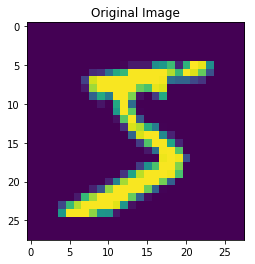

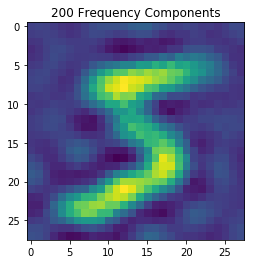

In [7]:
# Load image and normalize pixels to 0-1 range
img = np.array(mnist.train_data[0], dtype = 'float64')
img = img / 255

# Get image in the frequency domain
# Remove all but first 200 frequency components
img_hat = np.dot(np.transpose(U), img)
img_hat[200:] = 0
img_mod = np.dot(U, img_hat)

# Plot original and reconstructed images
plt.imshow(np.reshape(img, (28, 28)))
plt.title('Original Image')
plt.show()

plt.imshow(np.reshape(img_mod, (28, 28)))
plt.title('200 Frequency Components')
plt.show()

Any of the handwritten digits can be written as a linear combination of the 784 frequency components.

<h3>Spectral Filters</h3>

The point of a convolutional neural network is to learn an optimal filter with which the signal is convolved. For graph convolutional networks, it is common to use a filter which is polynomial in the frequency domain. In other words, when the filter signal $g$ is written in the frequency domain (rather than the vertex domain), we have
\begin{equation}
    \hat g_k = \sum_{i = 0}^n \alpha_{k,i} \lambda_k^i
\end{equation}
where $\alpha_{k,i}$ is the coefficient we are trying to learn, and $\lambda_k$ is the $k$th frequency of the graph.

<h4>Chebyshev Polynomials</h4>

Rather than learning $\alpha_{k,i}$ directly, it is common to work with Chebyshev polynomials, writing
\begin{equation}
    \hat g_k = \sum_{i = 0}^n \alpha_{k,i} \lambda_k^i = \sum_{i = 0}^n \theta_{k,i} T_i(\lambda_k - 1)
\end{equation}
Here $T_i(x)$ is the $i$th Chebyshev polynomial (of the first kind). Chebyshev polynomials are defined recursively, such that $T_0(x) = 1$, $T_1(x) = x$, and $T_{i + 1}(x) = 2 x T_i(x) - T_{i - 1}(x)$. They are defined over a domain $x \in [-1, 1]$ and have a range $T_i(x) \in [-1, 1]$. Note that eigenvalues of a normalized Laplacian lie between 0 and 2, so $\lambda_k - 1$ fits perfectly in the domain of a Chebyshev polynomial.

Chebyshev polynomials form an orthogonal basis for $n$th-degree polynomials over $x \in [-1, 1]$. Therefore, we are guaranteed that for every polynomial
\begin{equation}
    \hat g_k = \sum_{i = 0}^n \alpha_{k,i} \lambda_k^i
\end{equation}
we will be able to find coefficients $\theta_{k,i}$ to re-write the polynomial as a linear combination of Chebyshev polynomials:
\begin{equation}
    \hat g_k = \sum_{i = 0}^n \theta_{k,i} T_i(\lambda_k - 1)
\end{equation}
To find these coefficients, write out $T_i(x)$ as an explicit polynomial:
\begin{equation}
    T_i(x) = \sum_{j = 0}^n P_{i,j} x^j
\end{equation}
Here $P_{i,j}$ is the coefficient of $x^j$ in the $i$th Chebyshev polynomial. These coefficients can be found using the recursive definition:

In [8]:
def poly2ChebMatrix(n):
    
    # Initialize T0 and T1 base cases
    P = np.zeros((n, n))
    P[0,0] = 1
    P[1,1] = 1
    
    # Recursively fill in the rest of the matrix
    for i in range(2, n):        
        P[i,:] = 2 * np.pad(P[i-1,:], (1, 0), 'constant')[:-1] - P[i-2,:]
        
    return P

For example, we'll examine the Chebyshev polynomials $T_0, T_1, T_2, T_3$:

In [9]:
P = poly2ChebMatrix(4)
print(P)

[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [-1.  0.  2.  0.]
 [ 0. -3.  0.  4.]]


Reading this matrix, we find $T_0(x) = 1$ and $T_1(x) = x$, the desired base cases. Then $T_2(x) = -1 + 2x^2$, and $T_3(x) = -3x + 4x^3$. This can be verified from the Wikipedia list <a href="https://en.wikipedia.org/wiki/Chebyshev_polynomials#First_kind">here</a>.

Now, the goal of training the CNN is to identify the best coefficients $\theta_{k,i}$, yielding the optimal filter
\begin{equation}
    \hat g_k = \sum^n_{i = 0} \theta_{k,i} T_i(\lambda_k - 1)
\end{equation}
At some point, we will need to actually evaluate this sum. We can evaluate a vector of Chebyshev polynomials $T(x)$ using simple matrix multiplication. If we define a vector $y(x)$ of exponents, such that $y_i(x) = x^i$, then the vector of Chebyshev polynomials evaluated at $x$ is $T(x) = P y(x)$. 

To evaluate a weighted sum of Chebyshev polynomials at $x$, simply multiply by a weight vector $\theta$, where $\theta_i$ is the coefficient for the $i$th Chebyshev polynomial:
\begin{equation}
    t(x) = \sum_{i = 0}^n \theta_i T_i(x) = \theta^T P y(x)
\end{equation}

<h4>Chebyshev Filter</h4>

We will now carry out a convolution of a sample filter with the image. First, get the frequency components on the lattice graph and find the Fourier transform of the image:

In [10]:
L = get_lattice_laplacian(28)
[lamb, U] = np.linalg.eig(L)
img_hat = np.dot(np.transpose(U), img)

The filter is defined by the Chebyshev coefficients $\theta_{k, i}$ for each frequency component $k$. There are $28^2$ frequency components, and to start, we will use only the first 20 Chebyshev polynomials.

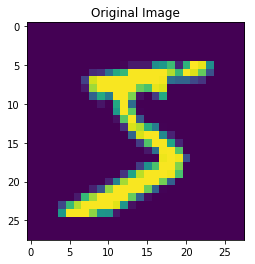

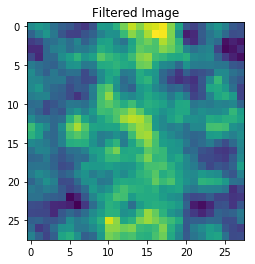

In [11]:
nComps = 28 ** 2  # Number of frequency components
nCoefs = 20       # Number of Chebyshev polynomials summed for each component

# Randomly initialize filter coefficients
theta = np.random.normal(0, 1e-2, (nComps, nCoefs)) 

# Prepare to store convolution in frequency domain
h_hat = np.empty(nComps)  

# Calculate polynomial-chebyshev change of basis matrix
P = poly2ChebMatrix(nCoefs)

for k in range(nComps):
    
    # Calculate filter polynomial for component k
    y = np.power(lamb[k] - 1, np.arange(nCoefs))
    g_hat = np.linalg.multi_dot([theta[k,:], P, y])
    h_hat[k] = img_hat[k] * g_hat
    
# Get convolution in vertex domain and plot
H = np.dot(U, h_hat)

plt.imshow(np.reshape(img, (28, 28)))
plt.title('Original Image')
plt.show()

plt.imshow(np.reshape(H, (28, 28)))
plt.title('Filtered Image')
plt.show()

<h2>Neural Network</h2>

First, we will pre-compute the Chebyshev polynomial values for each frequency component.

In [12]:
n_coefs = 6

# Get frequencies (eigenvalues of Laplacian)
L = get_lattice_laplacian(28)
[lamb, U] = np.linalg.eig(L)

# Shape frequencies as column vector and exponents as a row vector
powers = np.transpose(np.expand_dims(np.arange(n_coefs), 1))
freqs = np.expand_dims(lamb, 1)
Y = np.power(freqs, powers)

# Create matrix T of Chebyshev values
# T(k,i) is the value of the ith Chebyshev polynomial, evaluated at 
# frequency lamb(k)
P = poly2ChebMatrix(n_coefs)
T = np.dot(Y, P)

We can now evaluate the filter frequency component $k$ by $\hat g_k = T \theta$, where $\theta$ is the vector of Chebyshev coefficients that we are trying to learn. Even better, if we instead have several filters, with a matrix of coefficients $\Theta$, we can evaluate all of them at the same time by $\hat g_k = T \Theta$.

Finally, let's build a neural network.

In [5]:
def new_model(nVertices, nFilters, nDims, nCoefs):
    
    def model_fn(features, labels, mode, params):

        # 1. Configure model via TensorFlow operations

        # Define parameters to train
        # theta: (n_coefs x n_filters) filter coefficients
        # weights: (n_inputs * n_filters x n_dims) filter output weights for each dimension of embedding
        theta = tf.Variable(np.random.normal(0, 1e-2, size = (nCoefs, nFilters)))
        weights = tf.Variable(np.random.normal(0, 1e-2, size = (nVertices * nFilters, nDims)))

        # Unpack image 1 and image 2 into a layer
        # Compute their fourier transforms
        # x: (nVertices x N) input data
        # x_hat: (1 x n_inputs x N) input data in frequency domain
        x = tf.transpose(tf.reshape(features['x'], (-1, nInputs)))
        trans = np.transpose(params['U'])
        x_hat = tf.matmul(trans, x)

        # Calculate filter function and perform convolutions
        # filter_hat: (n_filters x n_inputs x 1) filter in frequency domain
        # conv_hat: (n_filters x n_inputs x N) convolution in frequency domain
        # conv: (n_filters x n_inputs x N) convolution in vertex domain
        # conv_flat: (n_inputs * n_filters X N) concatenate all filter convoultions into one vector
        filter_hat = tf.expand_dims(tf.transpose(tf.matmul(params['T'], theta)), axis = 2)
        conv_hat = img_hat * filter_hat
        conv = tf.tensordot(params['U'], conv_hat, axes = [[1], [1]])
        conv_flat = tf.reshape(conv, (n_inputs * n_filters, -1))

        # Use single layer to embed images
        # embed: (N x n_dims) embedding of each graph pair in the n_dims-dimensional plane
        # distances: (N) distances between each pair of graphs
        embed = tf.sigmoid(tf.matmul(tf.transpose(conv_flat), weights))

        # If we are predicting, and not calculating loss, stop now.
        if mode == tf.estimator.ModeKeys.PREDICT:
            return tf.estimator.EstimatorSpec(mode, {'embed': embed})

        # 2. Define loss function

        # Loss is computed by squared error between predicted graph distance
        # versus desired graph distance.
        # If images are in the same class, the distance should be zero.
        # Otherwise, distance should be higher.
        loss = tf.losses.mean_squared_error(labels, embed)

        # 3. Define training operation / optimizer

        optimizer = tf.train.GradientDescentOptimizer(learning_rate = params['learning_rate'])
        train_op = optimizer.minimize(loss = loss, global_step = tf.train.get_global_step())

        return tf.estimator.EstimatorSpec(mode, embed, loss, train_op, {})
    
    return model_fn

In [14]:
N_SAMPLES = 100000
DIGIT_SET = range(10)

# Prepare arrays to store training data and labels
data_cols = np.empty((N_SAMPLES, n_inputs), dtype = 'float')
labels = np.zeros((N_SAMPLES, len(DIGIT_SET)), dtype = 'float')

# Get list of candidate images belonging to DIGIT_SET
candidates = np.array([i for i in range(n_images) 
                       if mnist.train_labels[i] in DIGIT_SET])

# Populate training data / label arrays
for n in range(N_SAMPLES):
    
    # Select random image from candidates
    img_idx = np.random.choice(candidates)
    
    # Convert image to column vector and normalize pixels between 0 and 1
    data_cols[n, :] = np.array(mnist.train_data[img_idx], dtype = 'float') / 255
    
    # Create label for desired coordinate
    # 1 is [1, 0, 0, ...]; 2 is [0, 1, 0, ...], etc.
    d = np.where(np.array(DIGIT_SET) == mnist.train_labels[img_idx])
    labels[n, d] = 1

# Create input function
training_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {'img': data_cols},
    y = labels,
    shuffle = False
)

In [15]:
model_params = {}
model_params['U'] = U
model_params['T'] = T
model_params['learning_rate'] = 0.1

nn = tf.estimator.Estimator(model_fn = model_fn, params = model_params)
est = nn.train(input_fn = training_input_fn, steps = 500)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\KEVINS~1\\AppData\\Local\\Temp\\tmp1aj95qwc', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000000230CCCC0>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\KEVINS~1\AppData\Local\Temp\tmp1aj95qwc\model.ckpt.
INFO:tensorflow:loss = 0.250018, step = 1
INFO:tensorflow:global_step/sec: 39.0869
INFO:tensorflow:loss = 0.24905, step = 101 (2.558 sec)
INFO:tensorflow:global_step/sec: 45.4627
INFO:tensorflow:loss = 0.10575, step = 201 (2.200

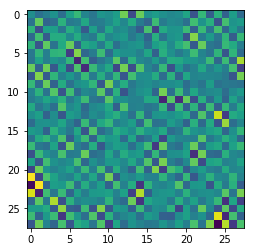

In [16]:
theta = est.get_variable_value('Variable')
filters = np.linalg.multi_dot([U, T, theta])

for n in range(n_filters):
    F = np.reshape(filters[:,n], (28, 28))
    plt.imshow(F)
    plt.show()

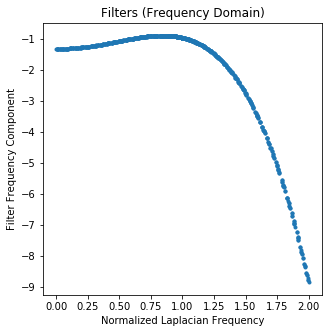

In [17]:
F = np.dot(T, theta)

fig = plt.figure(figsize = (5, 5))
plt.xlabel('Normalized Laplacian Frequency')
plt.ylabel('Filter Frequency Component')

for n in range(n_filters):
    plt.scatter(freqs, F[:,n], marker = '.')

plt.title('Filters (Frequency Domain)')
plt.show()

In [18]:
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {'img': data_cols[:10000,:]},
    num_epochs = 1,
    shuffle=False)

predictions = nn.predict(input_fn = predict_input_fn)
embeddings = np.vstack([pred['embed'] for pred in predictions])

INFO:tensorflow:Restoring parameters from C:\Users\KEVINS~1\AppData\Local\Temp\tmp1aj95qwc\model.ckpt-500


Project $n$-dimensional embedding into 2 dimensions for visualization, using PCA.

In [20]:
from sklearn.decomposition import PCA
pca = PCA(2)
pca.fit(embeddings)
Y = pca.transform(embeddings)

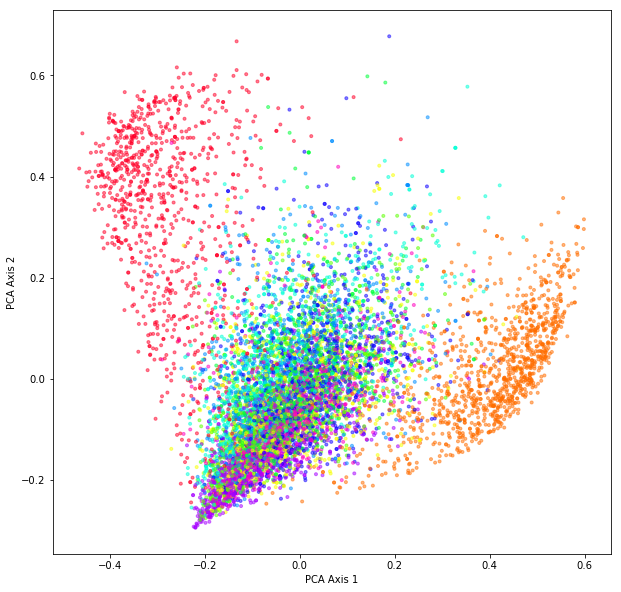

In [21]:
import matplotlib.colors

plt.figure(figsize = (10,10))
digits = np.dot(labels[:10000,:], np.arange(n_dims))
plt.scatter(Y[:,0], Y[:,1], marker = '.', alpha = 0.5, cmap = 'gist_rainbow', c = digits)
plt.xlabel('PCA Axis 1')
plt.ylabel('PCA Axis 2')
plt.show()